In [94]:
import analysis
import pandas as pd
import numpy as np
from scipy import stats
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import brewer


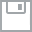
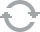
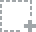
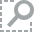
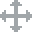
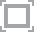
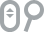
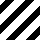
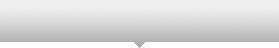
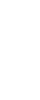
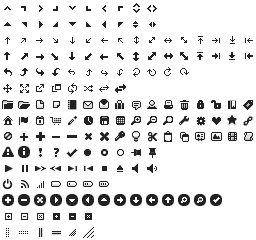
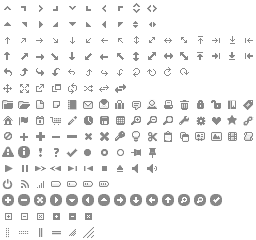
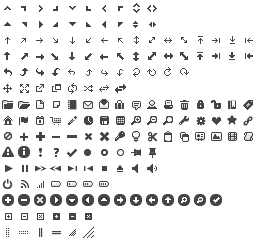
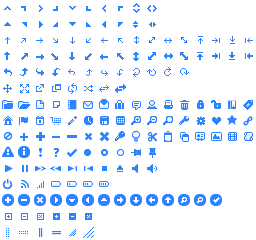
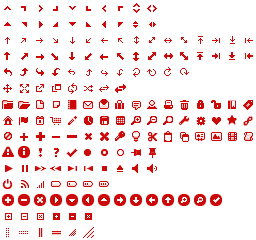
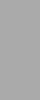
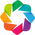
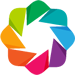

In [3]:
output_notebook()

In [6]:
# Download csv data here: https://research.stlouisfed.org/fred2/downloaddata/
# and change this variable to point to the main the unzipped directory
analysis.FRED_dir    = '/Users/tbk/FRED2_csv_2/'

# Download this file: http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt
# and change this variable to point to the text file
analysis.county_file = '/Users/tbk/national_county.txt'

### First, we will need to get a list of files from the FRED directory, and a dictionary of counties.

In [10]:
counties   = analysis.get_county_dict(analysis.county_file)
FRED_files = analysis.get_FRED_files(analysis.FRED_dir+'README_SERIES_ID_SORT.txt')

To demonstrate the format of the above:

In [13]:
print counties['27053'] # the best county in the world!
print FRED_files[0]

Hennepin County, MN
['0/00XALCATM086NEST.csv', 'Harmonized Index of Consumer Prices: Overall Index Excluding Alcohol and Tobacco for Austria\xc2\xa9', 'Index 2005=100', 'M', 'NSA', '2015-09-16']


### Next, we will extract the files which correspond to PCPI or population data, and aggregate them into a single dataframe.

In [14]:
# This cell will take several minutes to run!

# Load the PCPI files into a dataframe
PCPI_files = analysis.get_PCPI_files(FRED_files, counties.keys())
PCPI_data  = analysis.aggregate(PCPI_files, 'PCPI', verbose=False, save='')

# Load the POP files into a dataframe
# We will only use counties that have both sets,
# so we will only load data that was accessed in the PCPI dataframe
POP_files  = analysis.get_POP_files(FRED_files, PCPI_data.loaded, counties)
POP_data   = analysis.aggregate(POP_files, 'POP', verbose=False, save='')

# ...and then remove those few sets which had PCPI data but no POP data
to_remove  = [PCPI_FIP+'_'+PCPI_data.label for PCPI_FIP in PCPI_data.loaded if PCPI_FIP not in POP_data.loaded]
PCPI_data.drop(to_remove, axis=1, inplace=True)

### Let's transform the data into something a bit more manageable.

In [40]:
# Normalize PCPI values to 2015 USD and convert to units of thousands
PCPI_norm  = analysis.deflate(PCPI_data/1e3, norm_filename='C/P/I/CPIAUCSL.csv', base='2015')


# Take logarithm of POP data, then convert to thousands (add 3)
POP_log = POP_data.apply(np.log10) + 3

### Now we can do all kinds of cool things. Let's start with just plotting the data from the first year (1970) and the last (2013)...

In [86]:
year1 = '1970'
year2 = '2013'

f = figure(width = 900, height = 540, x_range=[0, 100], y_range=[0, 8], title='PCPI vs POP', \
           x_axis_label='Per Capita Personal Income (2015 Dollars, Thousands)', y_axis_label='Log County Population')
f.circle(PCPI_norm[year1].values[0], POP_log[year1].values[0], alpha=0.1, color='royalblue', legend=year1)
f.circle(PCPI_norm[year2].values[0], POP_log[year2].values[0], alpha=0.1, color='firebrick', legend=year2)
show(f)

### Let's look at some individual counties over time. First, we'll invert the `counties` dictionary to make it more human-friendly.

In [87]:
# Double check that the names of counties uniquely identify each position
# (otherwise we'll have errors which won't raise exceptions)
len(set(counties.keys())) == len(set(counties.values()))

True

In [91]:
# We're in the clear, so let's invert the dictionary
counties_inv = {name : FIPS for FIPS, name in counties.items()}

# and test it out
print counties_inv['Hennepin County, MN']
print counties[counties_inv['Hennepin County, MN']]

27053
Hennepin County, MN


In [117]:
state = 'MN'
counties_in_state = [key for key in counties_inv if key.split(',')[1].strip() == 'MN']

f = figure(width = 900, height = 540, x_range=[1970, 2013], title='PCPI in '+state, \
           x_axis_label='Year', y_axis_label='PCPI (2015 Dollars, Thousands)')

for c in counties_in_state:
    column_name = counties_inv[c]+'_PCPI'
    f.line(PCPI_norm.index.year, PCPI_norm[column_name].values)
    
show(f)

array([ 31.49527186,  31.8958943 ,  33.25123447,  34.83538278,
        34.42261046,  34.25232888,  35.25886619,  36.65759549,
        37.71911134,  38.15247853,  37.14461412,  36.83511937,
        37.20877031,  38.24133648,  40.76461855,  41.97750086,
        43.37344556,  44.56633633,  45.45036245,  46.6165904 ,
        46.4463369 ,  45.34088766,  46.71649709,  46.37499251,
        47.17841188,  48.88224657,  49.79613876,  52.24427426,
        55.54408158,  56.82267801,  59.41412415,  58.30382852,
        57.77626154,  58.66626738,  60.28777259,  60.47841709,
        62.30569252,  63.40236719,  62.28520031,  58.12077613,
        59.19044132,  60.30989211,  62.05691037,  61.56471266])